In [ ]:
### Using my developed metrics for nucleiDysmorphia analysis
### Created by Madeline E Melzer on 20230726, Last Edit by Madeline E Melzer on 20240111

In [40]:
import cv2
import glob
import numpy as np
import pandas as pd
import time, os, sys
from urllib.parse import urlparse
import skimage.io
import skimage
import cellpose
import imagecodecs
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
from urllib.parse import urlparse
from cellpose import models, core
from cellpose.io import logger_setup
from PIL import Image
from os import listdir
from os.path import isfile, join
from skimage import measure
import matplotlib.pyplot as plt
logger_setup();
import skimage.io as io
import math
import seaborn as sns
import re
import scipy
from scipy.special import ellipe

2024-01-14 16:35:28,056 [INFO] WRITING LOG OUTPUT TO /Users/mem3579/.cellpose/run.log
2024-01-14 16:35:28,057 [INFO] 
cellpose version: 	2.2.3 
platform:       	darwin 
python version: 	3.9.6 
torch version:  	2.1.1


In [70]:
### madeline testing stuff

dataPath = "/Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Collaborations/Arispe_Goyal/MadelineMelzer/DATA/nucleiDysmorphia/data/age_final/7wk/segmented/"
savePath = "/Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Collaborations/Arispe_Goyal/MadelineMelzer/DATA/nucleiDysmorphia/data/age_final/results/"

files = glob.glob(f"{dataPath}/*.tif")
dfResult_2 = main(files)

#file = "/Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Collaborations/Arispe_Goyal/MadelineMelzer/DATA/nucleiDysmorphia/data/age_final/7wk/segmented/MaxIP_2023_1005_Female2_647PECAM_568LaminA_488Vim__7wk_Arch_60x_1_cp_masks.tif"
#dfResult_2 = main(file)


#dfResult.to_csv(os.path.join(savePath, "20240114_newAges.csv"), index = False)

    label     area   perimeter  centroid-0  centroid-1  centroid_local-0  \
0       4  14185.0  459.102597  117.387452  361.528869         80.387452   
1       5  17163.0  546.901587  164.210919  199.773524        104.210919   
2       6  12447.0  470.818326  162.605367  852.065719         91.605367   
3       7  13503.0  449.203102  178.675776  498.248463         75.675776   
4       9  14253.0  569.445743  308.465165  728.992844        114.465165   
5      10  14399.0  508.830519  313.219668  384.757066         93.219668   
6      11  15699.0  590.759451  340.030384  942.044143        119.030384   
7      12  13067.0  504.960461  329.449223  293.380424        101.449223   
8      13  13958.0  522.901587  369.880069  118.054162        100.880069   
9      15  10621.0  461.806133  415.213822  873.598343         98.213822   
10     16  12607.0  521.931024  461.137225  575.898945        102.137225   
11     17  14269.0  503.788889  489.726049  209.068470         96.726049   
12     18  1

/var/folders/lj/t95zdh7s6q1728bs885tygr0f794qx/T/ipykernel_29504/3373444800.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_label.groupby('theta_bin')
/var/folders/lj/t95zdh7s6q1728bs885tygr0f794qx/T/ipykernel_29504/1471052531.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_rmssub = pd.concat([df_rmssub, new_row], ignore_index=True)
/var/folders/lj/t95zdh7s6q1728bs885tygr0f794qx/T/ipykernel_29504/3373444800.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pand

In [67]:
# pre-processing

def pre_process(file):
    masks = Image.open(file)
    masksArray = np.array(masks)

    if np.all(masksArray == 0):
        print(f"Skipping {file} because it has no mask signal")
        return None, None, None

    # Get the unique labels in the masksArray
    labels = np.unique(masksArray)
    labels = labels[labels != 0] # 0 is background

    # Initialize outlines as zeros array of same shape as masksArray
    outlines = np.zeros_like(masksArray)

    for label in labels:
        # Get binary mask for the current label
        binary_mask = (masksArray == label).astype(np.uint8)
        # Get contours for the binary mask
        contours = measure.find_contours(binary_mask, 0.5)
        # Draw contours on the outlines array
        for contour in contours:
            contour = np.around(contour).astype(int)
            outlines[contour[:, 0], contour[:, 1]] = 1

    contours = measure.find_contours(masksArray, 0.5)
    #print(contours)
    outlines = outlines.astype(np.uint8)

    return masksArray, outlines, contours

In [80]:
# rotate image

def rotate_image(image, orientation):
    angle = orientation * (180 / math.pi) + 90 # convert to degrees and add 90 to rotate to vertical
    rotated = scipy.ndimage.rotate(image, angle, reshape=False)
    return rotated

-0.2136200525124006
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
-0.0689896698223896
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
0.18202430878814535
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
-0.1439957538637958
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]

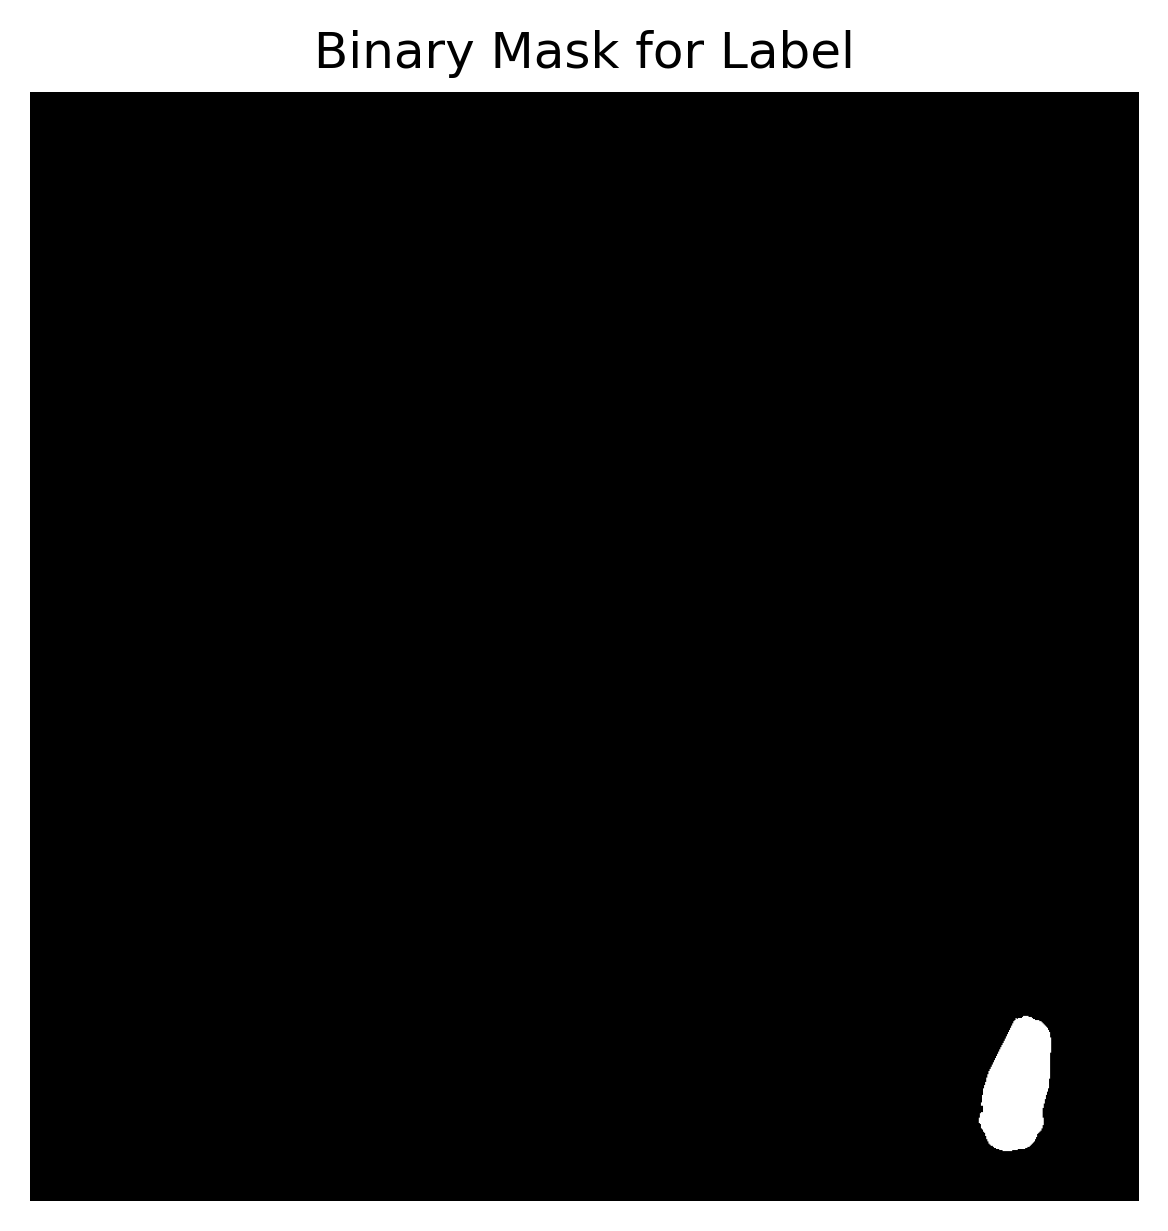

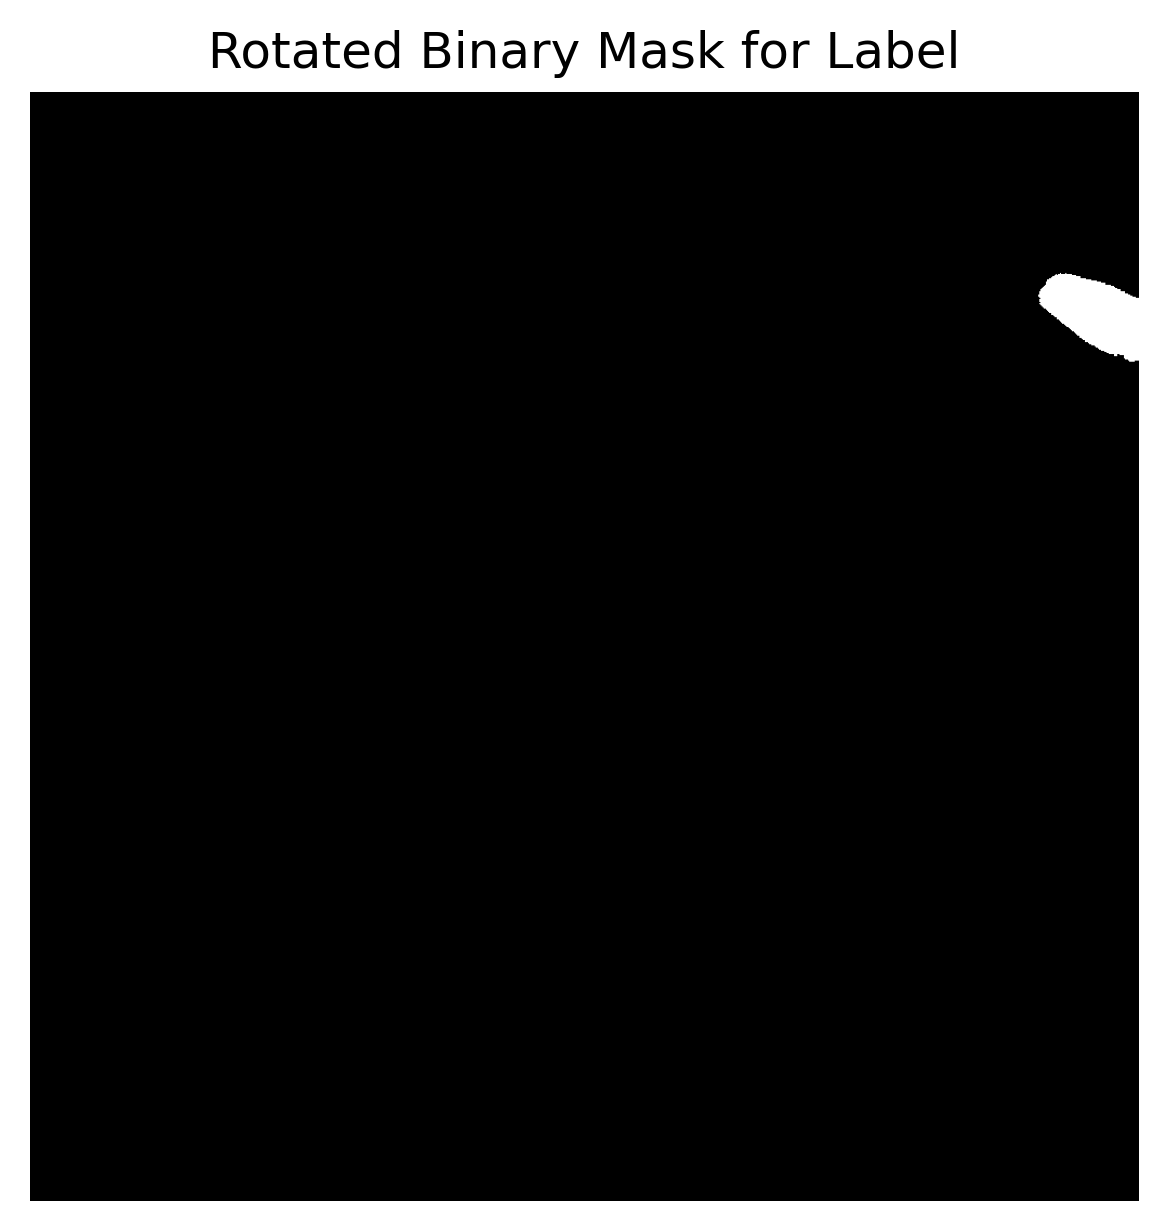

In [81]:
files = glob.glob(f"{dataPath}/*.tif")
for file in files:
    labeled_image, outlines, contours = pre_process(file)

    props = measure.regionprops_table(labeled_image, properties=['label',
                                                                    'area',
                                                                    'perimeter',
                                                                    'centroid',
                                                                    #'centroid_local',
                                                                    'major_axis_length',
                                                                    'minor_axis_length',
                                                                    'eccentricity',
                                                                    'solidity',
                                                                    'moments_hu',
                                                                    'equivalent_diameter_area',
                                                                    'area_bbox',
                                                                    'area_convex',
                                                                    #'area_filled',
                                                                    'extent',
                                                                    'feret_diameter_max',
                                                                    'perimeter_crofton',
                                                                    'orientation'])

    df_props = pd.DataFrame(props)
    df_props.insert(0, 'file', file)

    # To correct for 0.5 pixel offset between the center of pixel and pixel corners
            # mentioned in the regionprops documentation: https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure
    df_props['centroid-0'] += 0.5
    df_props['centroid-1'] += 0.5

    df_results = []

    for label in np.unique(labeled_image):
        if label == 0:
            continue

        print(df_props_label['orientation'].iloc[0])

        binary_mask_for_label = (labeled_image == label).astype(np.uint8)
        #print(binary_mask_for_label)
        df_props_label = df_props[df_props['label'] == label].copy()
        rotated_image = rotate_image(binary_mask_for_label, df_props_label['orientation'].iloc[0])
        #print(rotated_image)

plot_image(binary_mask_for_label, title="Binary Mask for Label")
plot_image(rotated_image, title="Rotated Binary Mask for Label")

In [78]:
import matplotlib.pyplot as plt

def plot_image(image_array, title="Image"):
    plt.imshow(image_array, cmap='gray')  # 'cmap' is the color map, 'gray' is typically used for grayscale images
    plt.title(title)
    plt.axis('off')  # Turn off axis numbers and labels
    plt.show()




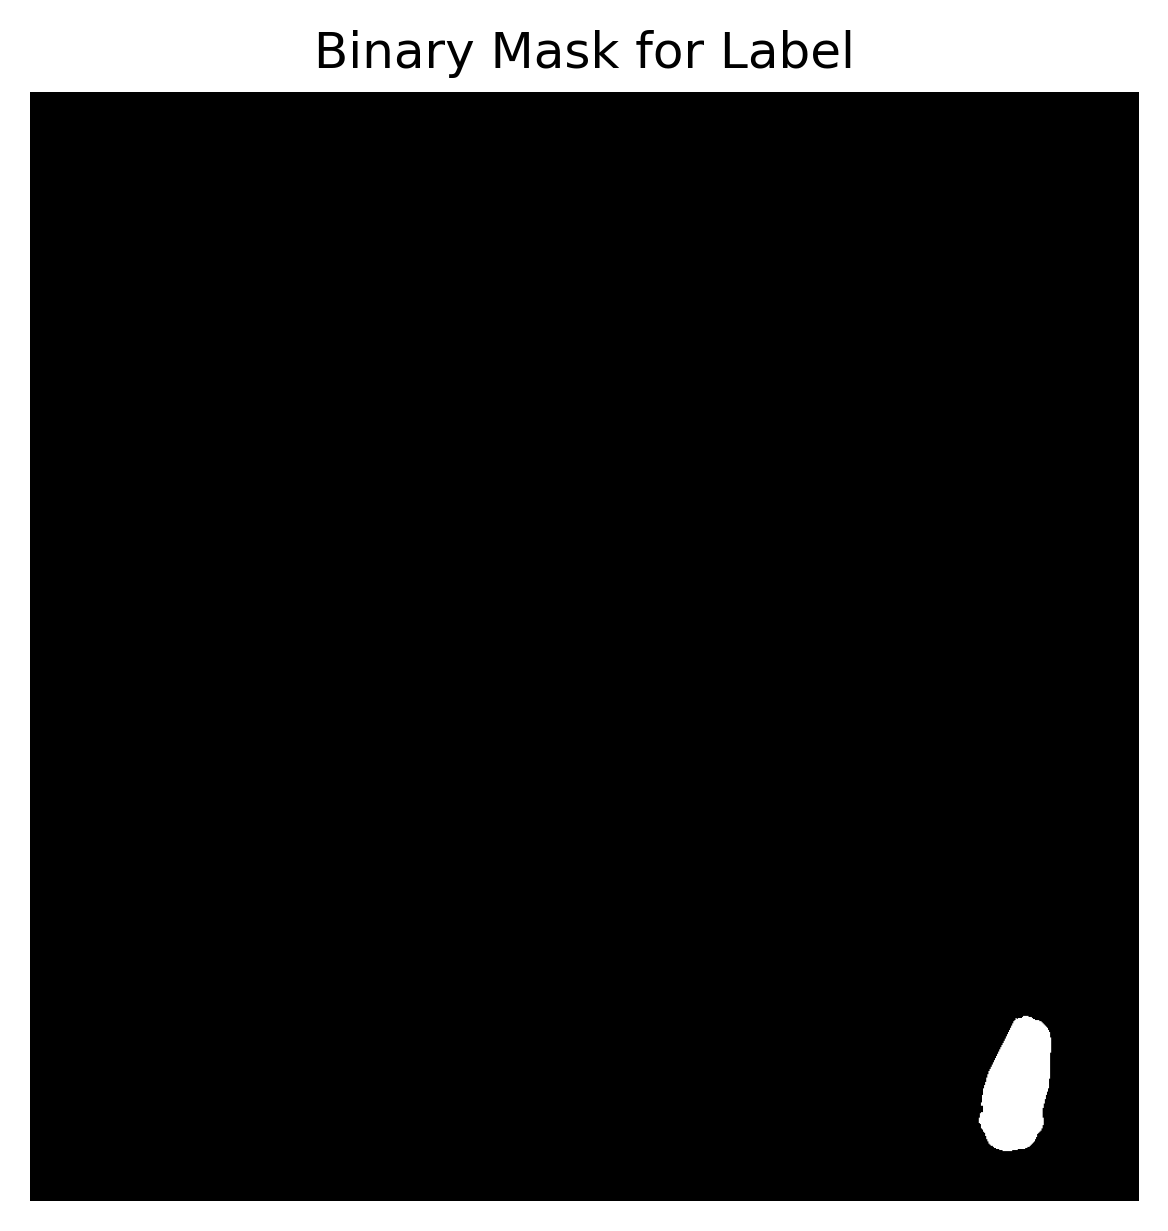

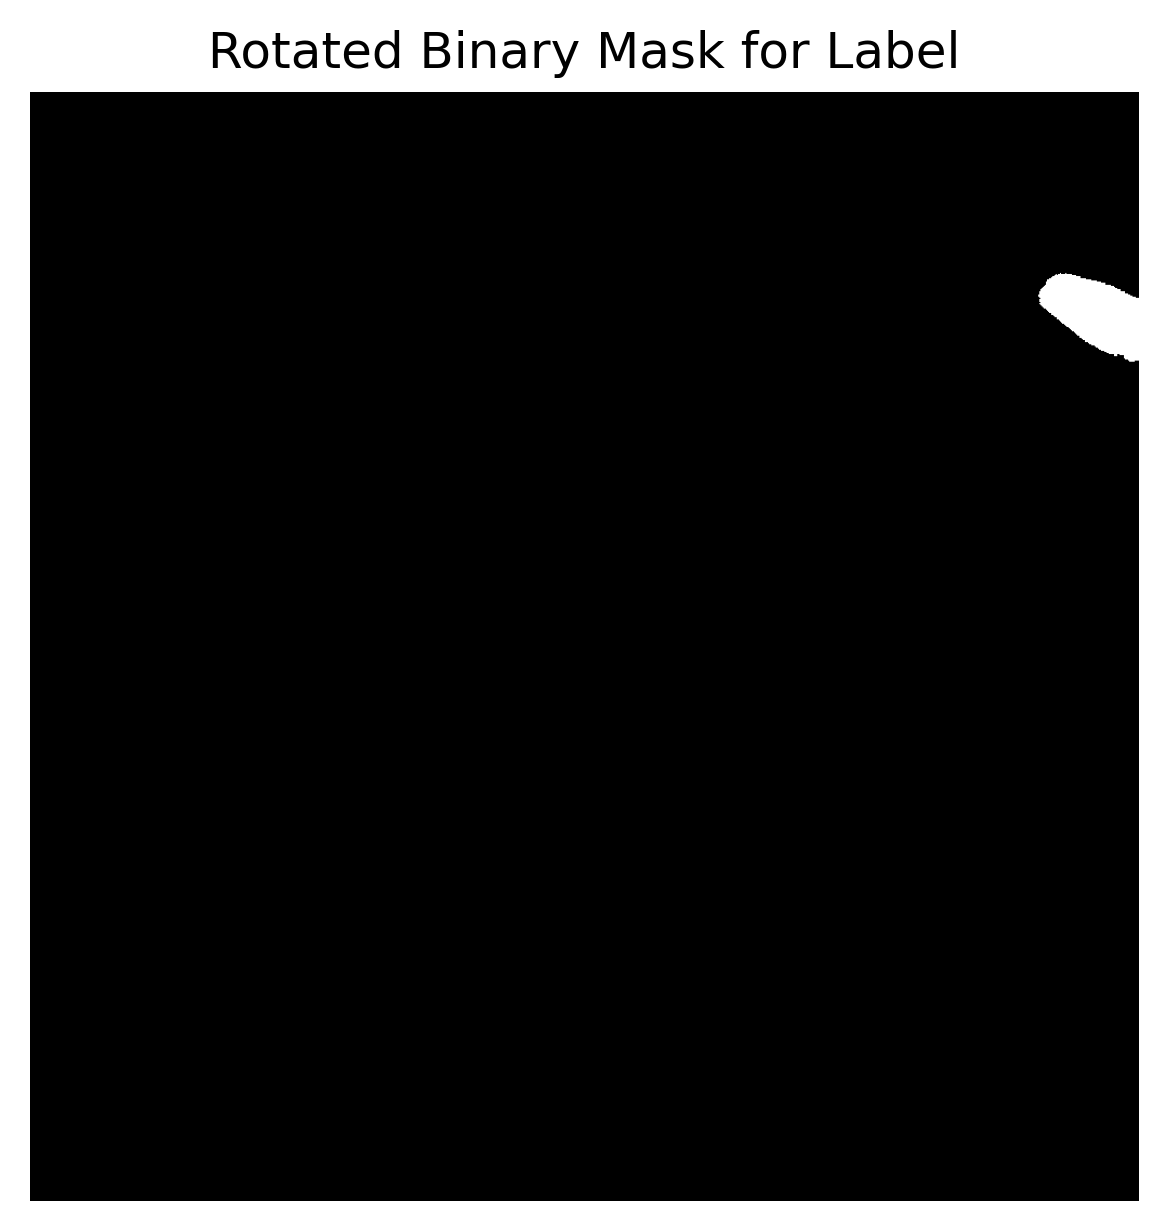

In [43]:
def rotate_point(x, y, angle):
    # Rotate a point counterclockwise by a given angle around the origin
    new_x = x * np.cos(angle) - y * np.sin(angle)
    new_y = x * np.sin(angle) + y * np.cos(angle)
    return new_x, new_y

def calculate_distances(binary_mask_for_label, df_props, label):
    # Find the coordinates of the outlines in binary_mask_for_label
    outlines = measure.find_contours(binary_mask_for_label, 0.5)
    #print(outlines)
    if outlines:
        outline = outlines[0]
        outline = np.round(outline).astype(int)
        coord = (outline[:, 0], outline[:, 1])
    else:
        return pd.DataFrame()

    distance_data = []
    
    df_props_label = df_props[df_props['label'] == label] # Filter df_props for the specified label

    for i in range(len(coord[0])):
        outline_x = coord[1][i]
        outline_y = coord[0][i]

        for index, row in df_props_label.iterrows():
            centroid_x = row['centroid-1']
            centroid_y = row['centroid-0']
            semi_major = row['major_axis_length']/2
            semi_minor = row['minor_axis_length']/2
            orientation = row['orientation']

            # Rotate outline point and centroid by the negative of the orientation angle

            rotated_outline_x, rotated_outline_y = rotate_point(outline_x - centroid_x, outline_y - centroid_y, -orientation)  # effectively puts point on the origin by subtracting the centroid and rotates it around the origin
            rotated_centroid_x, rotated_centroid_y = 0, 0  # The centroid becomes the origin after rotation

            r = math.dist((rotated_outline_y, rotated_outline_x), (rotated_centroid_y, rotated_centroid_x))
            theta = math.atan2((rotated_outline_y - rotated_centroid_y), (rotated_outline_x - rotated_centroid_x))

            r_norm = (semi_major*semi_minor)/(math.sqrt(((semi_major**2) * (math.sin(theta))**2) + ((semi_minor**2) * (math.cos(theta))**2))) #if the shape was perfectly elliptical, what would the radius at that theta be?
            r_rms = math.sqrt(abs((r**2)-(r_norm**2)))

            distance_data.append([
                row['label'], centroid_x, centroid_y, outline_x, outline_y, theta,
                r, r_norm, r_rms, row['major_axis_length'], row['minor_axis_length']
            ])

    df_distance = pd.DataFrame(distance_data, columns=[
        'label', 'centroid_x', 'centroid_y', 'outline_x', 'outline_y', 'theta',
        'r', 'r_norm', 'r_rms', 'major_axis_length', 'minor_axis_length'
    ])

    return df_distance


In [9]:
# root mean square average calculation

def calculate_rms_avgs(df_distance, label):
    df_distance_label = df_distance[df_distance['label'] == label]

    r_avgs = []
    rms_avgs = []
    r_diffs = []

    r_avg = df_distance_label['r'].mean()
    r_avgs.append(r_avg)

    rms_avg = df_distance_label['r_rms'].mean()
    rms_avgs.append(rms_avg)

    for i, row in df_distance_label.iterrows():
        r_diff = row['r'] - r_avg
        r_diffs.append(r_diff)

    return r_avgs, rms_avgs, r_diffs

In [10]:
# x-intercepts calculation (nuclear irregularity metric 1)

def calculate_x_intercepts(df_distance, label):
    df_distance_label = df_distance[df_distance['label'] == label]

    df_bin_avg = pd.DataFrame()

    df_label = df_distance_label.copy()
    df_label['theta_bin'] = pd.cut(df_label['theta'], np.arange(-np.pi, np.pi, 0.1), right=True)
    grouped = df_label.groupby('theta_bin', observed = False)

    for theta_bin, group in grouped:
        r_diff_bin = group['r_diff'].mean()
        new_data = {'label': label, 'bin': theta_bin, 'r_diff_bin': r_diff_bin}
        df_bin_avg = pd.concat([df_bin_avg, pd.DataFrame([new_data])], ignore_index=True)

    df_bin_avg['sign_change'] = np.sign(df_bin_avg['r_diff_bin']).diff().ne(0).astype(int)
    df_intercept = df_bin_avg[df_bin_avg['sign_change'] != 0]

    return df_bin_avg, df_intercept

In [18]:
# subsampling for root mean squared difference (nuclear irregularity metric 2)

def calculate_rms_diff(df_distance, label):
    df_distance_label = df_distance[df_distance['label'] == label]
    subsample_size = 50
    df_rmssub = pd.DataFrame(columns=['label', 'rms'])

    df_label = df_distance_label.sort_values('theta')
    num_points = len(df_label)

    if num_points > subsample_size:
        theta_points = np.arange(num_points)[::int(num_points/subsample_size)]
        rms_values = df_label.iloc[theta_points]['r_rms'].values
        rms_sub_avg = np.average(rms_values)
    else:
        rms_sub_avg = np.nan

    new_row = pd.DataFrame({'label': [label], 'rms': [rms_sub_avg]})
    if not new_row.isna().all(axis=1).any():  # Check if the row is not all-NA, this is to control for future pandas updates 
        df_rmssub = pd.concat([df_rmssub, new_row], ignore_index=True)

    return df_rmssub

In [12]:
# concavity count calculation (nuclear irregularity metric 3)

def calculate_concavity_ct(df_distance, label):
    df_distance_label = df_distance[df_distance['label'] == label]
    concavity_ct = 0
    theta_vals = np.unique(df_distance_label['theta'])

    for theta in theta_vals:
        r_vals = df_distance_label.loc[
            (df_distance_label['theta'] >= theta-0.002) &
            (df_distance_label['theta'] <= theta+0.002), 'r'].unique()

        if len(r_vals) > 1:
            concavity_ct += 1

    return [concavity_ct]

In [13]:
### post-processing functions for getting image-level information about the nuclei

# Extract age
def extract_age(filename):
    if re.search(r'52week|52wk|1year|1yo', filename):
        return 52
    elif re.search(r'24week|6mo', filename):
        return 24
    elif re.search(r'12week|12wk', filename):
        return 12
    elif re.search(r'7wk', filename):
        return 7
    else:
        return None

# Extract sex
def extract_sex(filename):
    match = re.search(r'(Male|Female)', filename)
    return match.group(1) if match else None

# Extract animal
def extract_animal(filename):
    match = re.search(r'(Male|Female)(\d+)', filename)
    return match.group(2) if match else None

# Extract location
def extract_location(filename):
    match = re.search(r'(Arch|Desc)', filename)
    return match.group(1) if match else None

# Extract image number
def extract_image_number(filename):
    match = re.search(r'60x_(\d)', filename)
    return match.group(1) if match else None

In [69]:

## main function

def main(files):
    dfResult = pd.DataFrame()

    for file in files:
        #print(file)
        labeled_image, outlines, contours = pre_process(file)

        if labeled_image is None:
            continue

        props = measure.regionprops_table(labeled_image, properties=['label',
                                                                'area',
                                                                'perimeter',
                                                                'centroid',
                                                                #'centroid_local',
                                                                'major_axis_length',
                                                                'minor_axis_length',
                                                                'eccentricity',
                                                                'solidity',
                                                                'moments_hu',
                                                                'equivalent_diameter_area',
                                                                'area_bbox',
                                                                'area_convex',
                                                                #'area_filled',
                                                                'extent',
                                                                'feret_diameter_max',
                                                                'perimeter_crofton',
                                                                'orientation'])

        df_props = pd.DataFrame(props)
        print(df_props)
        df_props.insert(0, 'file', file)

        # To correct for 0.5 pixel offset between the center of pixel and pixel corners
        # mentioned in the regionprops documentation: https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure
        df_props['centroid-0'] += 0.5
        df_props['centroid-1'] += 0.5

        df_results = []

        for label in np.unique(labeled_image):
            if label == 0:
                continue

            binary_mask_for_label = (labeled_image == label).astype(np.uint8)
            #print(binary_mask_for_label)
            df_props_label = df_props[df_props['label'] == label].copy()
            df_distance = calculate_distances(binary_mask_for_label, df_props_label, label)

            r_avgs, rms_avgs, r_diffs = calculate_rms_avgs(df_distance, label)

            df_distance['r_diff'] = r_diffs

            df_bin_avg, df_intercept = calculate_x_intercepts(df_distance, label)
            df_rmssub = calculate_rms_diff(df_distance, label)
            concav = calculate_concavity_ct(df_distance, label)
            
            e = df_props_label['eccentricity']

            df_props_label['perim_equivalent'] = 4 * (df_props_label['major_axis_length'] /2) * scipy.special.ellipe(e*e)
            df_props_label['dPerimeter'] = df_props_label['perimeter'] - df_props_label['perim_equivalent']
            df_props_label['area_equivalent'] = math.pi * (df_props_label['major_axis_length'] /2) * (df_props_label['minor_axis_length'] /2)
            df_props_label['dArea'] = df_props_label['area'] - df_props_label['area_convex']

            df_props_label['r_avg'] = r_avgs
            df_props_label['rms_avg'] = rms_avgs
            df_props_label['x_intercepts'] = df_intercept.groupby('label').size().tolist()
            df_props_label['rms_subsampled'] = df_rmssub['rms'].values.tolist()
            df_props_label['concavity_ct'] = list(concav)
            df_props_label['concavity_ct_log'] = np.log10(df_props_label['concavity_ct'])

            df_props_label['circularity'] = 4 * np.pi * df_props_label.loc[:, 'area'] / (df_props_label.loc[:, 'perimeter'] ** 2)
            #df_props_label['centroid_offset'] = np.sqrt((df_props_label['centroid-0'] - df_props_label['centroid_local-0'])**2 + (df_props_label['centroid-1'] - df_props_label['centroid_local-1'])**2)
            df_props_label['sphericity'] = df_distance['r'].max() - df_distance['r'].min()
            
            df_props_label['convexity'] = df_props_label['perimeter'] / df_props_label['area_convex']
            df_props_label['aspect_ratio'] = df_props_label['major_axis_length'] / df_props_label['minor_axis_length']
            df_props_label['flattening'] = (df_props_label['major_axis_length'] / df_props_label['minor_axis_length'])/df_props_label['major_axis_length']

            df_results.append(df_props_label)

        dfResult = pd.concat([dfResult, *df_results])

    #post-processing for age timecourse nuclei
    dfResult['age'] = dfResult['file'].apply(extract_age)
    dfResult['sex'] = dfResult['file'].apply(extract_sex)
    dfResult['animal'] = dfResult['file'].apply(extract_animal)
    dfResult['location'] = dfResult['file'].apply(extract_location)
    dfResult['imageNumber'] = dfResult['file'].apply(extract_image_number)



    return dfResult

In [22]:
## adding csv files together for ages

fileOne = pd.read_csv(os.path.join(savePath, "20231107_allAges.csv"))
fileTwo = pd.read_csv(os.path.join(savePath, "20231221_newAges.csv"))

combined_data = pd.concat([fileOne, fileTwo])

combined_data.to_csv("/Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Collaborations/Arispe_Goyal/MadelineMelzer/DATA/nucleiDysmorphia/data/age/output_metrics/20231221_allAges.csv")

In [ ]:
## Checking up on the Area (output bounds will be used as cutoffs for outliers in metricPlots.R)

#dfResult = pd.read_csv("/Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Collaborations/Arispe_Goyal/MadelineMelzer/DATA/nucleiDysmorphia/data/age/output_metrics/20231221_allAges.csv")

Q1 = dfResult['area'].quantile(0.25)
Q3 = dfResult['area'].quantile(0.75)
IQR = Q3 - Q1

# Calculate the outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Plotting histogram for the 'area' column in dfResult
plt.figure(figsize=(10, 6))
sns.histplot(dfResult['area'], kde=True, bins=30)
plt.axvline(Q1, color='r', linestyle='--', label='Q1 (25th quantile)')
plt.axvline(dfResult['area'].median(), color='g', linestyle='-', label='Median (50th quantile)')
plt.axvline(Q3, color='b', linestyle='--', label='Q3 (75th quantile)')
plt.axvline(lower_bound, color='red', linestyle='dashed', linewidth=2, label=f"Lower Bound: {{lower_bound:.2f}}")
plt.axvline(upper_bound, color='green', linestyle='dashed', linewidth=2, label=f"Upper Bound: {{upper_bound:.2f}}")
plt.legend()
plt.title('Histogram of Area with IQR')
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print("lower_bound = ", lower_bound)
print("upper_bound = ", upper_bound)